# Appendix: Multi-class target Variable Experiments 
For comparison of binary classes, 3 classes and one for each K6 score => 25 class models and their respective performance metrics. I had to do this to figure out if I had a better chance than a binary model to learn better for at_risk candidates.
I re-sed code from EDA and the main MAchine LEarning notebooks to clean out the data in the excat same way and then continued to perform the experiments on the same exact dataset.

It made sense at the end of all of them that the binary model performed best as the distribution across scores is heavily imbalanced and some scores have insignificant values under their class making it hard for models to learn anything despote their ensemble nature with more depth even. 

No need to go through entire notebook you can easily just refer to the last few visualizations and the last table to understand why I made the choice I did.

TLDR; I decided to stick to binary classification as it is the most acheivable given the high imbalance in target variables 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import xgboost as xgb

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, roc_auc_score, f1_score, make_scorer,
                             roc_curve, precision_recall_curve, accuracy_score, balanced_accuracy_score,
                            average_precision_score,
                            confusion_matrix, ConfusionMatrixDisplay)
                            


In [3]:
def load_variable_dictionary():
    """Load NHIS variable dictionary for readable names"""
    try:
        with open('nhis_variable_dictionary.json', 'r') as f:
            var_dict = json.load(f)
        print(f"✓ Dictionary loaded: {len(var_dict)} variables mapped")
        return var_dict
    except FileNotFoundError:
        print("⚠ Warning: Variable dictionary not found.")
        print("Run the dictionary creator script first, or continue with original names.")
        return 
        
# I will conert column names so I can understand what is going on 
def get_readable_name(code, var_dict):
    """Get readable name for a variable code"""
    return var_dict.get(code, code)

def format_column_names(df, columns, var_dict):
    """Create a mapping of original to readable names for given columns"""
    return {col: get_readable_name(col, var_dict) for col in columns}

# Load the dictionary
var_dict = load_variable_dictionary()

fatigue_vars = {
    'FGEFRQTRD_A': 'Fatigue: Frequency of feeling tired/exhausted (past 3 months)',
    'FGELNGTRD_A': 'Fatigue: Duration of tiredness periods',
}

# Update your dictionary
var_dict.update(fatigue_vars)

✓ Dictionary loaded: 363 variables mapped


In [4]:
value_labels = {
    'SEX_A': {1: 'Male', 2: 'Female'},
    
    'HISPALLP_A': {
        1: 'Hispanic',
        2: 'NH White',
        3: 'NH Black',
        4: 'NH Asian',
        5: 'NH AIAN',
        6: 'NH AIAN+Other',
        7: 'Other/Multiple'
    },
    
    'EDUCP_A': {
        1: 'Grade 1-11',
        2: '12th, no diploma',
        3: 'GED',
        4: 'HS Graduate',
        5: 'Some college',
        6: 'Assoc (voc)',
        7: 'Assoc (acad)',
        8: "Bachelor's",
        9: "Master's",
        10: 'Prof/Doctoral'
    },
    
    'MARITAL_A': {
        1: 'Married',
        2: 'With partner',
        3: 'Widowed',
        4: 'Divorced',
        5: 'Separated',
        6: 'Never married'
    },
    
    'PHSTAT_A': {
        1: 'Excellent',
        2: 'Very Good',
        3: 'Good',
        4: 'Fair',
        5: 'Poor'
    },
    
    'LSATIS4_A': {
        1: 'Very satisfied',
        2: 'Satisfied',
        3: 'Dissatisfied',
        4: 'Very dissatisfied'
    },
    
    'SMKCIGST_A': {
        1: 'Current',
        2: 'Former',
        3: 'Never',
        4: 'Unknown'
    }
}

# Binary (Yes/No) variables - Code 1=Yes, 2=No
binary_labels = {1: 'Yes', 2: 'No'}

## Load and Preprocess Dataset 

Since I did all the heavy lifting and analyzing in the EDA notebook I am just going to copy over the code from there that drops missing values > 70% columns, Fills in the nans where needed, imputes the values, constructs the new K6_Scorre column by re-encodin the 6 features to a 0-4 scoring scale. 

### Load Data

In [7]:
# Load dataset
df = pd.read_csv('adult24.csv')
df.head()

,RATCAT_A,INCTCFLG_A,IMPINCFLG_A,PPSU,PSTRAT,WLKLEISTC_A,WLKTRANTC_A,HISPALLP_A,RACEALLP_A,ANYDIFF_A,...,LSATIS4_A,PHSTAT_A,HHSTAT_A,INTV_MON,RECTYPE,IMPNUM_A,AVGNUMCIG_A,WTFA_A,HHX,POVRATTC_A
0,9,0,2,2,122,NaN,NaN,2,1,2,...,1,1,1,1,10,1,30,5780.565,H067658,2.82
1,8,0,0,2,122,20.0,NaN,2,1,2,...,2,2,1,1,10,1,20,3994.244,H076577,2.01
2,7,0,0,2,122,30.0,NaN,2,1,1,...,1,2,1,1,10,1,20,6636.755,H019335,1.90
3,12,0,0,2,122,10.0,NaN,2,1,1,...,2,3,1,1,10,1,01,13767.420,H012701,4.48
4,14,0,0,1,115,NaN,NaN,3,2,1,...,2,3,1,1,10,1,NaN,18880.030,H049678,6.37


### Preprocessing: K6 Scale construction

In [9]:
df_clean = df.copy()

In [10]:
# K6 components
k6_vars = ['SAD_A', 'NERVOUS_A', 'RESTLESS_A', 'HOPELESS_A', 'EFFORT_A', 'WORTHLESS_A']

# STEP 1: Recode to 0-4 scale (reverse the NHIS coding)
k6_recode = {
    5: 0,  # None of the time
    4: 1,  # A little
    3: 2,  # Some
    2: 3,  # Most
    1: 4,  # All of the time
    7: np.nan,  # Refused
    8: np.nan,  # Not ascertained
    9: np.nan   # Don't know
}

# Apply recoding to each K6 component
for var in k6_vars:
    df_clean[f'{var}_recoded'] = df_clean[var].map(k6_recode)

# STEP 2: Calculate K6 score (sum of all 6 components)
# Only calculate if ALL six components are non-missing
recoded_vars = [f'{var}_recoded' for var in k6_vars]
df_clean['K6_SCORE'] = df_clean[recoded_vars].sum(axis=1, min_count=6)  # min_count=6 means all must be non-null

# STEP 3: Create binary target (K6 >= 5 = eligible for preventative care)
df_clean['at_risk'] = (df_clean['K6_SCORE'] >= 5).astype(float)

print("\nK6 Score Statistics:")
print(df_clean['K6_SCORE'].describe())


K6 Score Statistics:
count    31813.000000
mean         2.720492
std          3.860018
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max         24.000000
Name: K6_SCORE, dtype: float64


### Preprocessing: Missing Data

In [12]:
# Step 1: Keep only observations with valid K6 scores
print(df_clean.shape)
valid_k6 = df_clean['K6_SCORE'].notna()
df_clean = df_clean[valid_k6]

# Step 2: Drop high-missingness variables (>70%)
cols_to_check = df_clean.select_dtypes(include=[np.number]).columns
missing_pct = df_clean[cols_to_check].isnull().sum() / len(df_clean)
high_missing_cols = missing_pct[missing_pct > 0.7].index.tolist()

df_clean = df_clean.drop(columns=high_missing_cols)
print(df_clean.shape)

(32629, 638)
(31813, 365)


### Preprocessing: Median Imputation 

In [14]:
# Step 3: Identify predictor columns (exclude K6-related and admin variables)
exclude_from_imputation = [
    # K6-related
    'K6_SCORE', 'at_risk', 'high_distress', 'distress_threshold',
    'SAD_A', 'NERVOUS_A', 'RESTLESS_A', 'HOPELESS_A', 'EFFORT_A', 'WORTHLESS_A',
    'SAD_A_recoded', 'NERVOUS_A_recoded', 'RESTLESS_A_recoded', 
    'HOPELESS_A_recoded', 'EFFORT_A_recoded', 'WORTHLESS_A_recoded',
    'DEPFREQ_A', 'ANXFREQ_A', 'DEPLEVEL_A', 'ANXLEVEL_A', 'DEPMED_A', 'ANXMED_A', 'K6SPD_A',
    'ANXEV_A', 'DEPEV_A', 'MHRX_A', 'MHTHRPY_A', 'MHTHND_A', 'MHTHDLY_A',
    'cluster',
    # Admin
    'HHX', 'WTFA_A', 'PPSU', 'PSTRAT', 'RECTYPE', 'SRVY_YR', 'IMPNUM_A', 
    'HHSTAT_A', 'ASTATNEW',
]

# Get numeric columns that should be imputed
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
cols_to_impute = [col for col in numeric_cols if col not in exclude_from_imputation]

# Step 4: Apply median imputation
missing_before = df_clean[cols_to_impute].isnull().sum().sum()
imputer = SimpleImputer(strategy='median')
df_clean[cols_to_impute] = imputer.fit_transform(df_clean[cols_to_impute])

missing_after = df_clean[cols_to_impute].isnull().sum().sum()
print(f"  Missing values after: {missing_after:,}")
df_clean.shape

  Missing values after: 0


(31813, 365)

## Data Preparation

This section I will work on splitting the dataset into train-test-validation sets so that we are not overfitting and also have eyes on our metrics as we go through each experiment. I will also be defining the dataset as feature (`X`) and target arrays (`y`). When doing so I have to make sure I remove the K6 scale features from the dataset so as to not be included in the inputs and cause leakage. Before I split the dataset I need to make sure I go ahead with endoing all the variables - if they are ordinal (a lot of them), nominal or just cateogrical - I need to makes sure they are encoded with their own customer encodings so as to take into account the right representations in comparison to the target.

Finally, since I was already able to apply median imputation in the preprocessing stage I will skip that here and only apply standardizing the numerical features. Standardizing helps remove the weights that might be on certain features and values because all features have their own range of values and so to be able to do a fair comparison we must bring all values across all numerical features to the same range, for e.g. 0-1.

*Edit: I had to add some manual cleaning variables and dictionaries since ordinal variables would need appropriate encoding teechniques applied to them. Ordinal features were ery high in this dataset so I want to make sure I am hadling them correctly

### Variable Encodings

In [17]:
# Define ALL K6-related variables (including non-recoded versions)
K6_ALL_VARS = [
    # Original K6 component questions (INCLUDE THESE!)
    'SAD_A', 
    'NERVOUS_A', 
    'RESTLESS_A', 
    'HOPELESS_A', 
    'EFFORT_A', 
    'WORTHLESS_A',
    # Recoded versions
    'SAD_A_recoded', 
    'NERVOUS_A_recoded', 
    'RESTLESS_A_recoded',
    'HOPELESS_A_recoded', 
    'EFFORT_A_recoded', 
    'WORTHLESS_A_recoded',
    # Derived variables
    'K6_SCORE', 
    'K6SPD_A',
    'at_risk', 
    'age_group'
]

print(f"\nK6 leakage variables to exclude: {len(K6_ALL_VARS)}")
print(f"Variables: {K6_ALL_VARS}")


K6 leakage variables to exclude: 16
Variables: ['SAD_A', 'NERVOUS_A', 'RESTLESS_A', 'HOPELESS_A', 'EFFORT_A', 'WORTHLESS_A', 'SAD_A_recoded', 'NERVOUS_A_recoded', 'RESTLESS_A_recoded', 'HOPELESS_A_recoded', 'EFFORT_A_recoded', 'WORTHLESS_A_recoded', 'K6_SCORE', 'K6SPD_A', 'at_risk', 'age_group']


In [18]:
# ORDINAL
ordinal_vars = [
    # Education (clear progression)
    'EDUCP_A',
    
    # Health status (excellent → poor)
    'PHSTAT_A',    # General health: 1=Excellent, 5=Poor
    'MHSTAT_A',    # Mental health: 1=Excellent, 5=Poor
    
    # Frequency variables (daily → never)
    'ANXFREQ_A',   # Anxiety frequency
    'DEPFREQ_A',   # Depression frequency
    'WORFREQ_A',   # Worry frequency
    
    # Smoking/Alcohol (never → heavy use)
    'SMKSTAT_A',   # Smoking status
    'ALCSTAT_A',   # Alcohol status
    
    # Difficulty variables (no difficulty → cannot do)
    'DIFF_A',
    'DIFICLN_A',
    'DIFHEAR_A',
    'DIFSEE_A',
    'DIFWALK_A',
    'DIFREM_A',
    
    # Financial/Healthcare access
    'PAYBLL12M_A',  # Problems paying bills
    'PDMED12M_A',   # Delayed medical care
    'PNMED12M_A',   # Needed but couldn't afford
    
    # Social variables
    'LSATIS4_A',    # Life satisfaction
    'SUPPORT_A',    # Social support
    'LONELY_A',     # Loneliness
    
    # Physical activity frequencies
    'MODFREQW_A',
    'VIGFREQW_A',
    'STRFREQW_A',
    
    # Employment (some ordering by economic security)
    'EMPSTAT_A',
]

# NOMINAL: Variables with no meaningful order
nominal_vars = [
    'SEX_A',        # Male/Female
    'HISPALLP_A',   # Hispanic ethnicity
    'RACEALLP_A',   # Race
    'MARITAL_A',    # Marital status
    'REGIONP_A',    # Geographic region
    'URBRRL_A',     # Urban/rural
]

print(f"Ordinal variables defined: {len(ordinal_vars)}")
print(f"Nominal variables defined: {len(nominal_vars)}")

# Check which variables actually exist in the dataset
ordinal_present = [v for v in ordinal_vars if v in df_clean.columns]
ordinal_missing = [v for v in ordinal_vars if v not in df_clean.columns]

nominal_present = [v for v in nominal_vars if v in df_clean.columns]
nominal_missing = [v for v in nominal_vars if v not in df_clean.columns]

print(f"\nOrdinal variables in dataset: {len(ordinal_present)}/{len(ordinal_vars)}")
print(f"  Present: {ordinal_present[:5]}...")
if len(ordinal_missing) > 0:
    print(f"  Missing: {ordinal_missing}")

print(f"\nNominal variables in dataset: {len(nominal_present)}/{len(nominal_vars)}")
print(f"  Present: {nominal_present}")
if len(nominal_missing) > 0:
    print(f"  Missing: {nominal_missing}")

Ordinal variables defined: 24
Nominal variables defined: 6

Ordinal variables in dataset: 12/24
  Present: ['EDUCP_A', 'PHSTAT_A', 'ANXFREQ_A', 'DEPFREQ_A', 'DIFF_A']...
  Missing: ['MHSTAT_A', 'WORFREQ_A', 'SMKSTAT_A', 'ALCSTAT_A', 'DIFICLN_A', 'DIFHEAR_A', 'DIFSEE_A', 'DIFWALK_A', 'DIFREM_A', 'PDMED12M_A', 'PNMED12M_A', 'EMPSTAT_A']

Nominal variables in dataset: 4/6
  Present: ['SEX_A', 'HISPALLP_A', 'RACEALLP_A', 'MARITAL_A']
  Missing: ['REGIONP_A', 'URBRRL_A']


The reason we see that features here are "missing" is because I probably dropped them in my EDA where I found >70% missing data.

In [20]:
# Remove K6 variables and target
exclude_vars = K6_ALL_VARS.copy()

# Get all potential features
all_features = [col for col in df_clean.columns if col not in exclude_vars]

# Create feature matrix
X_raw = df_clean[all_features].copy()

# Create target (remove rows where at_risk is missing)
y = df_clean['at_risk'].copy()
valid_indices = y.notna()

X_raw = X_raw[valid_indices]
y = y[valid_indices].astype(int).values

print(f"\nFinal dataset shape: {X_raw.shape}")
print(f"Target shape: {y.shape}")

# Class distribution
n_not_risk = (y == 0).sum()
n_at_risk = (y == 1).sum()
imbalance_ratio = n_not_risk / n_at_risk

print(f"\nClass distribution:")
print(f"  Not at-risk (0): {n_not_risk:,} ({n_not_risk/len(y)*100:.1f}%)")
print(f"  At-risk (1): {n_at_risk:,} ({n_at_risk/len(y)*100:.1f}%)")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")


Final dataset shape: (31813, 350)
Target shape: (31813,)

Class distribution:
  Not at-risk (0): 24,996 (78.6%)
  At-risk (1): 6,817 (21.4%)
  Imbalance ratio: 3.67:1


Things are looking good so far, all the claims made in the EDA notebook are adding up to the cleanup and setup I have implemented so far

Because of the sheer colume of features and survey type responses I wanted to be as meticulous as my time provided to separate out and clearly define variables based on the encodings I going to apply to them. So below is the code for creating lists of the variety of variables such that they can be easily grouped and encoded together.

In [23]:
# Update to only include variables that exist in X_raw
ordinal_cols = [col for col in ordinal_present if col in X_raw.columns]
nominal_cols = [col for col in nominal_present if col in X_raw.columns]

# Remaining numeric columns (continuous)
numeric_cols = [col for col in X_raw.columns 
                if col not in ordinal_cols + nominal_cols 
                and X_raw[col].dtype in ['int64', 'float64']]

print(f"Ordinal columns: {len(ordinal_cols)}")
print(f"  {ordinal_cols[:10]}")

print(f"\nNominal columns: {len(nominal_cols)}")
print(f"  {nominal_cols}")

print(f"\nNumeric (continuous) columns: {len(numeric_cols)}")
print(f"  {numeric_cols[:10]}...")

print(f"\nTotal: {len(ordinal_cols) + len(nominal_cols) + len(numeric_cols)}")
print(f"X_raw columns: {X_raw.shape[1]}")

Ordinal columns: 12
  ['EDUCP_A', 'PHSTAT_A', 'ANXFREQ_A', 'DEPFREQ_A', 'DIFF_A', 'PAYBLL12M_A', 'LSATIS4_A', 'SUPPORT_A', 'LONELY_A', 'MODFREQW_A']

Nominal columns: 4
  ['SEX_A', 'HISPALLP_A', 'RACEALLP_A', 'MARITAL_A']

Numeric (continuous) columns: 332
  ['RATCAT_A', 'INCTCFLG_A', 'IMPINCFLG_A', 'PPSU', 'PSTRAT', 'WLKLEISTC_A', 'ANYDIFF_A', 'DISAB3_A', 'NUMBRN1TC_A', 'AFNOW']...

Total: 348
X_raw columns: 350


Before I go ahead and encode the variables I just categorized, I need to make sure that there are no nulls and if so I have the correct representation for them depending on the category of variable and dtype. For numeric ( I already did this step in EDA but for completeness we will check again) I will apply median imputation as I mentioned before it is the most robust choice.

For ordinal I am chossing mode imputation as the most frrequently answered response can be substituted - we can have continous values like numeric. The same logic applies to nominal features where we can assume the most frequent answer choice to be the replacement value when choosing form non ordered options. 

In [25]:
X_imputed = X_raw.copy()

# Check missing data
missing_summary = X_imputed.isnull().sum()
cols_with_missing = missing_summary[missing_summary > 0]

print(f"Columns with missing data: {len(cols_with_missing)}")
if len(cols_with_missing) > 0:
    print(f"\nTop 10 columns with most missing:")
    print(cols_with_missing.nlargest(10))

# Impute numeric/continuous
if len(numeric_cols) > 0:
    numeric_imputer = SimpleImputer(strategy='median')
    X_imputed[numeric_cols] = numeric_imputer.fit_transform(X_imputed[numeric_cols])
    print(f"Imputed {len(numeric_cols)} numeric columns with median")

# Impute ordinal (use mode)
if len(ordinal_cols) > 0:
    ordinal_imputer = SimpleImputer(strategy='most_frequent')
    X_imputed[ordinal_cols] = ordinal_imputer.fit_transform(X_imputed[ordinal_cols])
    print(f"Imputed {len(ordinal_cols)} ordinal columns with mode")

# Impute nominal (use mode)
if len(nominal_cols) > 0:
    nominal_imputer = SimpleImputer(strategy='most_frequent')
    X_imputed[nominal_cols] = nominal_imputer.fit_transform(X_imputed[nominal_cols])
    print(f"Imputed {len(nominal_cols)} nominal columns with mode")



Columns with missing data: 4

Top 10 columns with most missing:
AVGNUMCIG_A    20358
DEPLEVEL_A     16500
ANXLEVEL_A      8947
MHRX_A          5718
dtype: int64
Imputed 332 numeric columns with median
Imputed 12 ordinal columns with mode
Imputed 4 nominal columns with mode


I think my stratergy works here as average ciggarettes would mostly be no response since most of the participants were non smokers. And so the most frequent response works best as replacement. 

Finally, lets encode all these variables before we start the model fitting phase

In [28]:
X_encoded = X_imputed.copy()

# Encode ordinal variables (preserve order)
if len(ordinal_cols) > 0:
    ordinal_encoder = OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    )
    X_encoded[ordinal_cols] = ordinal_encoder.fit_transform(X_encoded[ordinal_cols])
    print(f"Ordinal encoded {len(ordinal_cols)} columns")

if len(nominal_cols) > 0:
    # Check which nominal columns still exist
    nominal_cols_available = [col for col in nominal_cols if col in X_encoded.columns]
    
    print(f"Nominal columns to encode: {len(nominal_cols_available)}/{len(nominal_cols)}")
    print(f"Available: {nominal_cols_available}")
    
    if len(nominal_cols_available) > 0:
        print(f"One-hot encoding {len(nominal_cols_available)} nominal variables...")
        
        # Check data types
        for col in nominal_cols_available:
            dtype = X_encoded[col].dtype
            n_unique = X_encoded[col].nunique()
            print(f"  {col}: dtype={dtype}, {n_unique} categories")
        
        # CONVERT TO CATEGORICAL/OBJECT DTYPE FIRST
        for col in nominal_cols_available:
            X_encoded[col] = X_encoded[col].astype('object')
        
        print(f"Converted to object dtype")
        
        # Now one-hot encode
        X_nominal_dummies = pd.get_dummies(
            X_encoded[nominal_cols_available],
            drop_first=True,
            prefix=nominal_cols_available
        )
        
        # Drop original nominal columns
        X_encoded = X_encoded.drop(columns=nominal_cols_available)
        
        # Add dummy variables
        X_encoded = pd.concat([X_encoded, X_nominal_dummies], axis=1)
        
        print(f"Created {X_nominal_dummies.shape[1]} dummy variables from {len(nominal_cols_available)} nominal columns")
    else:
        print(f"No nominal columns available for encoding")

print(f"\nFinal encoded shape: {X_encoded.shape}")

Ordinal encoded 12 columns
Nominal columns to encode: 4/4
Available: ['SEX_A', 'HISPALLP_A', 'RACEALLP_A', 'MARITAL_A']
One-hot encoding 4 nominal variables...
  SEX_A: dtype=float64, 4 categories
  HISPALLP_A: dtype=float64, 7 categories
  RACEALLP_A: dtype=float64, 9 categories
  MARITAL_A: dtype=float64, 6 categories
Converted to object dtype
Created 22 dummy variables from 4 nominal columns

Final encoded shape: (31813, 368)


After a lot of debugging I was able to succesfully encode each variable according to its characteristics. This is an important step for my model to react appropriately to the data and learn from it. 
The next step can now be to split up the X,y in to train, test and validation 

## Split Dataset: Train-Test-Val

I chose the standard 80/20 split in this case as it works pretty well and with the target imbalance we would like to have as much training data as possible to learn from. I chose to make the validation as 20% too to ensure we ar enot overfitting. Another point to mention here is that it is important to stratify on y such that the imbalance is accounted for in the three different splits and maintains the proportions of at-risk/not-at-risk across the splits.

In [31]:
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# Second split: 60% train, 20% val (from the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 0.25 of 80% = 20% of total
    random_state=42,
    stratify=y_temp
)

print(f"Train set: {len(X_train):,} samples ({len(X_train)/len(y)*100:.1f}%)")
print(f"  Not at-risk: {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"  At-risk: {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")

print(f"\nValidation set: {len(X_val):,} samples ({len(X_val)/len(y)*100:.1f}%)")
print(f"  Not at-risk: {(y_val==0).sum():,} ({(y_val==0).sum()/len(y_val)*100:.1f}%)")
print(f"  At-risk: {(y_val==1).sum():,} ({(y_val==1).sum()/len(y_val)*100:.1f}%)")

print(f"\nTest set: {len(X_test):,} samples ({len(X_test)/len(y)*100:.1f}%)")
print(f"  Not at-risk: {(y_test==0).sum():,} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"  At-risk: {(y_test==1).sum():,} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")

Train set: 19,087 samples (60.0%)
  Not at-risk: 14,997 (78.6%)
  At-risk: 4,090 (21.4%)

Validation set: 6,363 samples (20.0%)
  Not at-risk: 4,999 (78.6%)
  At-risk: 1,364 (21.4%)

Test set: 6,363 samples (20.0%)
  Not at-risk: 5,000 (78.6%)
  At-risk: 1,363 (21.4%)


### Feature Scaling 
A quick but important stept to standardize each category of variables to a standard range of values across the repsectie cateogry (ordinal, nominal, numeric)

In [33]:
# Check data types before scaling
print("Checking data types...")
non_numeric = X_train.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

if len(non_numeric) > 0:
    print(f"Found {len(non_numeric)} non-numeric columns:")
    for col in non_numeric[:10]:
        print(f"  {col}: dtype={X_train[col].dtype}, sample values={X_train[col].unique()[:5]}")
    
    # Convert any remaining non-numeric columns to numeric (force)
    print("\nConverting non-numeric columns to numeric...")
    for col in non_numeric:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
    
    # Fill any NaNs created by conversion
    X_train = X_train.fillna(0)
    X_val = X_val.fillna(0)
    X_test = X_test.fillna(0)
    
    print(f"Converted and filled NaNs")

# Now scale
scaler = StandardScaler()

# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"\n Scaled features to mean=0, std=1")
print(f"  Fitted on train set only (prevents leakage)")
print(f"  Applied same transformation to val and test")

print(f"\nTrain scaled shape: {X_train_scaled.shape}")
print(f"Val scaled shape: {X_val_scaled.shape}")
print(f"Test scaled shape: {X_test_scaled.shape}")

# Store feature names
feature_names = X_train_scaled.columns.tolist()
print(f"\nTotal features: {len(feature_names)}")

Checking data types...
Found 24 non-numeric columns:
  AVGNUMCIG_A: dtype=object, sample values=['20' nan '04' '06' '10']
  HHX: dtype=object, sample values=['H020507' 'H047406' 'H014152' 'H037124' 'H027181']
  SEX_A_2.0: dtype=bool, sample values=[False  True]
  SEX_A_7.0: dtype=bool, sample values=[False  True]
  SEX_A_9.0: dtype=bool, sample values=[False  True]
  HISPALLP_A_2.0: dtype=bool, sample values=[False  True]
  HISPALLP_A_3.0: dtype=bool, sample values=[ True False]
  HISPALLP_A_4.0: dtype=bool, sample values=[False  True]
  HISPALLP_A_5.0: dtype=bool, sample values=[False  True]
  HISPALLP_A_6.0: dtype=bool, sample values=[False  True]

Converting non-numeric columns to numeric...
Converted and filled NaNs

 Scaled features to mean=0, std=1
  Fitted on train set only (prevents leakage)
  Applied same transformation to val and test

Train scaled shape: (19087, 368)
Val scaled shape: (6363, 368)
Test scaled shape: (6363, 368)

Total features: 368


### Dataset Check 
Quick erification that I can start trianing with the dataset now

In [35]:
# Check for K6 leakage
leaked_features = []
for feat in feature_names:
    for k6_var in K6_ALL_VARS:
        if k6_var.lower() in feat.lower():
            leaked_features.append(feat)
            break

if len(leaked_features) == 0:
    print("NO K6 LEAKAGE DETECTED")
    print("  All K6 component variables successfully excluded")
else:
    print(f"⚠ WARNING: {len(leaked_features)} potential leakage features found:")
    for feat in leaked_features[:10]:
        print(f"  - {feat}")

print(f"""
Summary:
  - K6 variables excluded: {len(K6_ALL_VARS)}
  - Features: {len(feature_names)}
  - Ordinal encoding: {len(ordinal_cols)} variables
  - One-hot encoding: {len(nominal_cols)} variables
  - No missing data
  - Train/Val/Test: {len(X_train)}/{len(X_val)}/{len(X_test)}
  - Stratified splits maintain {imbalance_ratio:.1f}:1 ratio
""")

NO K6 LEAKAGE DETECTED
  All K6 component variables successfully excluded

Summary:
  - K6 variables excluded: 16
  - Features: 368
  - Ordinal encoding: 12 variables
  - One-hot encoding: 4 variables
  - No missing data
  - Train/Val/Test: 19087/6363/6363
  - Stratified splits maintain 3.7:1 ratio



Here is a quick summarized version of why we did this comprehesive data setup before moving to the next phase:

**Explanation:** We start with a careful data split that stratifies by the target to maintain the ~3.7:1 class imbalance in both train and test sets. This is crucial for honest evaluation. We explicitly exclude all K6 component questions from the feature set to prevent data leakage - using parts of the K6 score to predict the K6 score would artificially inflate performance. Features are imputed (median strategy for robustness) and standardized (important for logistic regression and neural networks, less critical for tree-based methods).

## Modelling Comparisons
- First for binary vs 25
- then for binary vs 3 classes
- and then an overall view as well for all three 


K6 Score Distribution in Training Data:

K6 Score range: 0 to 24
Unique K6 scores: 25

K6 Score Distribution (Train set):
K6_SCORE
0.0     7804
1.0     2412
2.0     2247
3.0     1294
4.0     1240
5.0      744
6.0      784
7.0      448
8.0      412
9.0      328
10.0     277
11.0     203
12.0     216
13.0     156
14.0     135
Name: count, dtype: int64

Multi-class target shape:
  Train: (19087,) (25 classes)
  Validation: (6363,)
  Test: (6363,)

Class balance for multi-class:


,K6_Score,Count,Percentage
0,0.0,7804,40.886467
1,1.0,2412,12.636873
2,2.0,2247,11.772411
3,3.0,1294,6.779483
4,4.0,1240,6.496568
5,5.0,744,3.897941
6,6.0,784,4.107508
7,7.0,448,2.347147
8,8.0,412,2.158537
9,9.0,328,1.718447


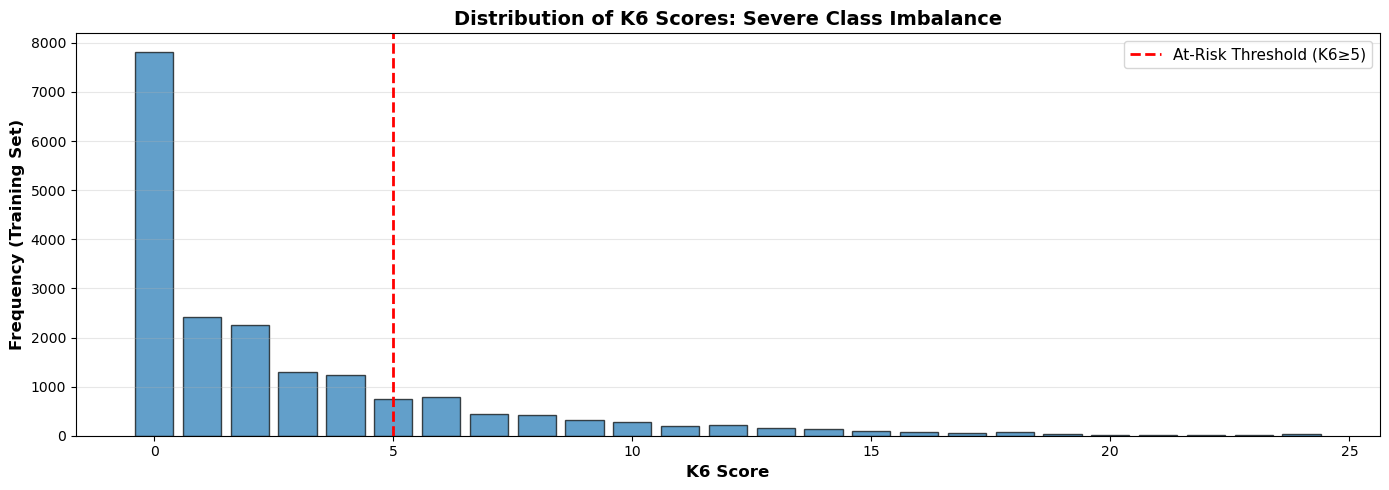


⚠️ CHALLENGE: Severe class imbalance
  Most common class (K6=0): 40.9%
  Least common classes (K6>15): <1% each


In [38]:
# Check K6 score distribution
print("\nK6 Score Distribution in Training Data:")
k6_train = df_clean.loc[X_train.index, 'K6_SCORE']
k6_val = df_clean.loc[X_val.index, 'K6_SCORE']
k6_test = df_clean.loc[X_test.index, 'K6_SCORE']

print(f"\nK6 Score range: {k6_train.min():.0f} to {k6_train.max():.0f}")
print(f"Unique K6 scores: {k6_train.nunique()}")

# Distribution
k6_dist = k6_train.value_counts().sort_index()
print(f"\nK6 Score Distribution (Train set):")
print(k6_dist.head(15))

# Create multi-class targets
y_train_multiclass = k6_train.values
y_val_multiclass = k6_val.values
y_test_multiclass = k6_test.values

print(f"\nMulti-class target shape:")
print(f"  Train: {y_train_multiclass.shape} ({len(np.unique(y_train_multiclass))} classes)")
print(f"  Validation: {y_val_multiclass.shape}")
print(f"  Test: {y_test_multiclass.shape}")

# Check class imbalance for multi-class
unique_classes, counts = np.unique(y_train_multiclass, return_counts=True)
class_dist = pd.DataFrame({'K6_Score': unique_classes, 'Count': counts, 'Percentage': counts/counts.sum()*100})
class_dist = class_dist.sort_values('K6_Score')

print(f"\nClass balance for multi-class:")
display(class_dist)

# Visualize distribution
plt.figure(figsize=(14, 5))
plt.bar(class_dist['K6_Score'], class_dist['Count'], edgecolor='black', alpha=0.7)
plt.axvline(x=5, color='red', linestyle='--', linewidth=2, label='At-Risk Threshold (K6≥5)')
plt.xlabel('K6 Score', fontsize=12, fontweight='bold')
plt.ylabel('Frequency (Training Set)', fontsize=12, fontweight='bold')
plt.title('Distribution of K6 Scores: Severe Class Imbalance', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n⚠️ CHALLENGE: Severe class imbalance")
print(f"  Most common class (K6=0): {class_dist.iloc[0]['Percentage']:.1f}%")
print(f"  Least common classes (K6>15): <1% each")

In [39]:
print("\n" + "="*80)
print("MODEL 1: BINARY CLASSIFICATION (K6 < 5 vs K6 ≥ 5)")
print("="*80)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Binary model with your best parameters
binary_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='aucpr',
    n_jobs=-1
)

print("Training binary classification model...")
binary_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

# Predictions
y_test_pred_binary = binary_model.predict(X_test_scaled)
y_test_proba_binary = binary_model.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*80)
print("BINARY MODEL: Test Set Performance")
print("="*80)
print(classification_report(y_test, y_test_pred_binary, 
                          target_names=['Not At-Risk', 'At-Risk'], digits=4))

# Key metrics
binary_accuracy = accuracy_score(y_test, y_test_pred_binary)
binary_balanced_acc = balanced_accuracy_score(y_test, y_test_pred_binary)
binary_roc_auc = roc_auc_score(y_test, y_test_proba_binary)
binary_f1_macro = f1_score(y_test, y_test_pred_binary, average='macro')
binary_f1_at_risk = f1_score(y_test, y_test_pred_binary, pos_label=1)

cm_binary = confusion_matrix(y_test, y_test_pred_binary)
binary_sensitivity = cm_binary[1,1] / (cm_binary[1,1] + cm_binary[1,0])
binary_specificity = cm_binary[0,0] / (cm_binary[0,0] + cm_binary[0,1])

print(f"\nBinary Model Summary:")
print(f"  Accuracy: {binary_accuracy:.4f}")
print(f"  Balanced Accuracy: {binary_balanced_acc:.4f}")
print(f"  ROC-AUC: {binary_roc_auc:.4f}")
print(f"  At-Risk Recall: {binary_sensitivity:.4f} ({binary_sensitivity*100:.1f}%)")
print(f"  At-Risk Precision: {cm_binary[1,1]/(cm_binary[1,1]+cm_binary[0,1]):.4f}")
print(f"  At-Risk F1: {binary_f1_at_risk:.4f}")

# Store results
binary_results = {
    'accuracy': binary_accuracy,
    'balanced_accuracy': binary_balanced_acc,
    'roc_auc': binary_roc_auc,
    'f1_macro': binary_f1_macro,
    'at_risk_recall': binary_sensitivity,
    'at_risk_f1': binary_f1_at_risk
}


MODEL 1: BINARY CLASSIFICATION (K6 < 5 vs K6 ≥ 5)
Training binary classification model...

BINARY MODEL: Test Set Performance
              precision    recall  f1-score   support

 Not At-Risk     0.9341    0.9036    0.9186      5000
     At-Risk     0.6841    0.7660    0.7227      1363

    accuracy                         0.8741      6363
   macro avg     0.8091    0.8348    0.8207      6363
weighted avg     0.8805    0.8741    0.8766      6363


Binary Model Summary:
  Accuracy: 0.8741
  Balanced Accuracy: 0.8348
  ROC-AUC: 0.9240
  At-Risk Recall: 0.7660 (76.6%)
  At-Risk Precision: 0.6841
  At-Risk F1: 0.7227


In [40]:
print("\n" + "="*80)
print("MODEL 2: MULTI-CLASS CLASSIFICATION (Predict Exact K6 Score 0-24)")
print("="*80)

# Multi-class XGBoost
multiclass_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='multi:softmax',  # Multi-class classification
    num_class=int(y_train_multiclass.max() + 1),  # Number of classes
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1
)

print(f"Training multi-class model (predicting {int(y_train_multiclass.max() + 1)} K6 scores)...")
multiclass_model.fit(
    X_train_scaled, y_train_multiclass,
    eval_set=[(X_val_scaled, y_val_multiclass)],
    verbose=False
)

# Predictions
y_test_pred_multiclass = multiclass_model.predict(X_test_scaled)
y_test_proba_multiclass = multiclass_model.predict_proba(X_test_scaled)

print("\n✓ Multi-class model trained")

# Convert multi-class predictions back to binary for comparison
y_test_pred_multiclass_binary = (y_test_pred_multiclass >= 5).astype(int)

# Also get probability of being at-risk (sum probabilities for K6 ≥ 5)
y_test_proba_multiclass_at_risk = y_test_proba_multiclass[:, 5:].sum(axis=1)

print("\n" + "="*80)
print("MULTI-CLASS MODEL: Test Set Performance (Exact K6 Prediction)")
print("="*80)

# Exact match accuracy
multiclass_exact_accuracy = accuracy_score(y_test_multiclass, y_test_pred_multiclass)
print(f"Exact K6 Score Accuracy: {multiclass_exact_accuracy:.4f} ({multiclass_exact_accuracy*100:.1f}%)")
print(f"  → Model predicts EXACT K6 score correctly {multiclass_exact_accuracy*100:.1f}% of the time")

# Mean Absolute Error
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_multiclass, y_test_pred_multiclass)
rmse = np.sqrt(mean_squared_error(y_test_multiclass, y_test_pred_multiclass))

print(f"\nPrediction Error:")
print(f"  Mean Absolute Error: {mae:.2f} points")
print(f"  Root Mean Squared Error: {rmse:.2f} points")
print(f"  → On average, predictions are off by {mae:.1f} K6 points")

# Within-1-point accuracy
within_1 = np.abs(y_test_multiclass - y_test_pred_multiclass) <= 1
within_1_accuracy = within_1.mean()
print(f"\nWithin ±1 Point Accuracy: {within_1_accuracy:.4f} ({within_1_accuracy*100:.1f}%)")

within_2 = np.abs(y_test_multiclass - y_test_pred_multiclass) <= 2
within_2_accuracy = within_2.mean()
print(f"Within ±2 Points Accuracy: {within_2_accuracy:.4f} ({within_2_accuracy*100:.1f}%)")

print("\n" + "="*80)
print("MULTI-CLASS MODEL: Binary Classification Performance (K6<5 vs K6≥5)")
print("="*80)

# Evaluate as binary classifier
print(classification_report(y_test, y_test_pred_multiclass_binary,
                          target_names=['Not At-Risk', 'At-Risk'], digits=4))

multiclass_accuracy = accuracy_score(y_test, y_test_pred_multiclass_binary)
multiclass_balanced_acc = balanced_accuracy_score(y_test, y_test_pred_multiclass_binary)
multiclass_roc_auc = roc_auc_score(y_test, y_test_proba_multiclass_at_risk)
multiclass_f1_macro = f1_score(y_test, y_test_pred_multiclass_binary, average='macro')
multiclass_f1_at_risk = f1_score(y_test, y_test_pred_multiclass_binary, pos_label=1)

cm_multiclass = confusion_matrix(y_test, y_test_pred_multiclass_binary)
multiclass_sensitivity = cm_multiclass[1,1] / (cm_multiclass[1,1] + cm_multiclass[1,0])
multiclass_specificity = cm_multiclass[0,0] / (cm_multiclass[0,0] + cm_multiclass[0,1])

print(f"\nMulti-class (as Binary) Summary:")
print(f"  Binary Accuracy: {multiclass_accuracy:.4f}")
print(f"  Balanced Accuracy: {multiclass_balanced_acc:.4f}")
print(f"  ROC-AUC: {multiclass_roc_auc:.4f}")
print(f"  At-Risk Recall: {multiclass_sensitivity:.4f} ({multiclass_sensitivity*100:.1f}%)")
print(f"  At-Risk Precision: {cm_multiclass[1,1]/(cm_multiclass[1,1]+cm_multiclass[0,1]):.4f}")
print(f"  At-Risk F1: {multiclass_f1_at_risk:.4f}")

# Store results
multiclass_results = {
    'exact_accuracy': multiclass_exact_accuracy,
    'within_1_accuracy': within_1_accuracy,
    'mae': mae,
    'binary_accuracy': multiclass_accuracy,
    'balanced_accuracy': multiclass_balanced_acc,
    'roc_auc': multiclass_roc_auc,
    'f1_macro': multiclass_f1_macro,
    'at_risk_recall': multiclass_sensitivity,
    'at_risk_f1': multiclass_f1_at_risk
}


MODEL 2: MULTI-CLASS CLASSIFICATION (Predict Exact K6 Score 0-24)
Training multi-class model (predicting 25 K6 scores)...

✓ Multi-class model trained

MULTI-CLASS MODEL: Test Set Performance (Exact K6 Prediction)
Exact K6 Score Accuracy: 0.4397 (44.0%)
  → Model predicts EXACT K6 score correctly 44.0% of the time

Prediction Error:
  Mean Absolute Error: 1.57 points
  Root Mean Squared Error: 2.70 points
  → On average, predictions are off by 1.6 K6 points

Within ±1 Point Accuracy: 0.6274 (62.7%)
Within ±2 Points Accuracy: 0.7828 (78.3%)

MULTI-CLASS MODEL: Binary Classification Performance (K6<5 vs K6≥5)
              precision    recall  f1-score   support

 Not At-Risk     0.8745    0.9710    0.9202      5000
     At-Risk     0.8212    0.4886    0.6127      1363

    accuracy                         0.8677      6363
   macro avg     0.8478    0.7298    0.7665      6363
weighted avg     0.8631    0.8677    0.8543      6363


Multi-class (as Binary) Summary:
  Binary Accuracy: 0.86

In [41]:
print("\n" + "="*80)
print("HEAD-TO-HEAD COMPARISON: Binary vs Multi-Class")
print("="*80)

comparison_df = pd.DataFrame({
    'Metric': [
        'Binary Classification Accuracy',
        'Balanced Accuracy',
        'ROC-AUC',
        'Macro F1',
        'At-Risk Recall (Sensitivity)',
        'At-Risk F1',
        '---',
        'Exact K6 Score Accuracy',
        'Within ±1 Point Accuracy',
        'Mean Absolute Error (points)'
    ],
    'Binary Model': [
        f"{binary_results['accuracy']:.4f}",
        f"{binary_results['balanced_accuracy']:.4f}",
        f"{binary_results['roc_auc']:.4f}",
        f"{binary_results['f1_macro']:.4f}",
        f"{binary_results['at_risk_recall']:.4f}",
        f"{binary_results['at_risk_f1']:.4f}",
        '---',
        'N/A',
        'N/A',
        'N/A'
    ],
    'Multi-Class Model': [
        f"{multiclass_results['binary_accuracy']:.4f}",
        f"{multiclass_results['balanced_accuracy']:.4f}",
        f"{multiclass_results['roc_auc']:.4f}",
        f"{multiclass_results['f1_macro']:.4f}",
        f"{multiclass_results['at_risk_recall']:.4f}",
        f"{multiclass_results['at_risk_f1']:.4f}",
        '---',
        f"{multiclass_results['exact_accuracy']:.4f}",
        f"{multiclass_results['within_1_accuracy']:.4f}",
        f"{multiclass_results['mae']:.2f}"
    ],
    'Winner': [
        'Binary' if binary_results['accuracy'] > multiclass_results['binary_accuracy'] else 'Multi-Class',
        'Binary' if binary_results['balanced_accuracy'] > multiclass_results['balanced_accuracy'] else 'Multi-Class',
        'Binary' if binary_results['roc_auc'] > multiclass_results['roc_auc'] else 'Multi-Class',
        'Binary' if binary_results['f1_macro'] > multiclass_results['f1_macro'] else 'Multi-Class',
        'Binary' if binary_results['at_risk_recall'] > multiclass_results['at_risk_recall'] else 'Multi-Class',
        'Binary' if binary_results['at_risk_f1'] > multiclass_results['at_risk_f1'] else 'Multi-Class',
        '---',
        'Multi-Class',
        'Multi-Class',
        'Multi-Class'
    ]
})

display(comparison_df)

# Statistical comparison
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

recall_diff = binary_results['at_risk_recall'] - multiclass_results['at_risk_recall']
roc_diff = binary_results['roc_auc'] - multiclass_results['roc_auc']

print(f"\nAt-Risk Identification (Most Important for Intervention):")
print(f"  Binary Model Recall: {binary_results['at_risk_recall']*100:.1f}%")
print(f"  Multi-Class Model Recall: {multiclass_results['at_risk_recall']*100:.1f}%")
print(f"  Difference: {abs(recall_diff)*100:.1f} percentage points")

if abs(recall_diff) < 0.02:
    print(f"  → SIMILAR PERFORMANCE (difference <2%)")
elif recall_diff > 0:
    print(f"  → BINARY MODEL BETTER at catching at-risk individuals")
else:
    print(f"  → MULTI-CLASS MODEL BETTER at catching at-risk individuals")

print(f"\nDiscrimination Ability (ROC-AUC):")
print(f"  Binary Model: {binary_results['roc_auc']:.4f}")
print(f"  Multi-Class Model: {multiclass_results['roc_auc']:.4f}")
print(f"  Difference: {abs(roc_diff):.4f}")

if abs(roc_diff) < 0.01:
    print(f"  → EQUIVALENT PERFORMANCE")
elif roc_diff > 0:
    print(f"  → BINARY MODEL BETTER discrimination")
else:
    print(f"  → MULTI-CLASS MODEL BETTER discrimination")

print(f"\nAdditional Insights from Multi-Class:")
print(f"  • Exact K6 prediction: {multiclass_results['exact_accuracy']*100:.1f}% (challenging with 25 classes)")
print(f"  • Within ±1 point: {multiclass_results['within_1_accuracy']*100:.1f}%")
print(f"  • Average error: {multiclass_results['mae']:.1f} K6 points")


HEAD-TO-HEAD COMPARISON: Binary vs Multi-Class


,Metric,Binary Model,Multi-Class Model,Winner
0,Binary Classification Accuracy,0.8741,0.8677,Binary
1,Balanced Accuracy,0.8348,0.7298,Binary
2,ROC-AUC,0.9240,0.9263,Multi-Class
3,Macro F1,0.8207,0.7665,Binary
4,At-Risk Recall (Sensitivity),0.7660,0.4886,Binary
5,At-Risk F1,0.7227,0.6127,Binary
6,---,---,---,---
7,Exact K6 Score Accuracy,N/A,0.4397,Multi-Class
8,Within ±1 Point Accuracy,N/A,0.6274,Multi-Class
9,Mean Absolute Error (points),N/A,1.57,Multi-Class



KEY FINDINGS

At-Risk Identification (Most Important for Intervention):
  Binary Model Recall: 76.6%
  Multi-Class Model Recall: 48.9%
  Difference: 27.7 percentage points
  → BINARY MODEL BETTER at catching at-risk individuals

Discrimination Ability (ROC-AUC):
  Binary Model: 0.9240
  Multi-Class Model: 0.9263
  Difference: 0.0023
  → EQUIVALENT PERFORMANCE

Additional Insights from Multi-Class:
  • Exact K6 prediction: 44.0% (challenging with 25 classes)
  • Within ±1 point: 62.7%
  • Average error: 1.6 K6 points



VISUALIZATION: Model Performance Comparison


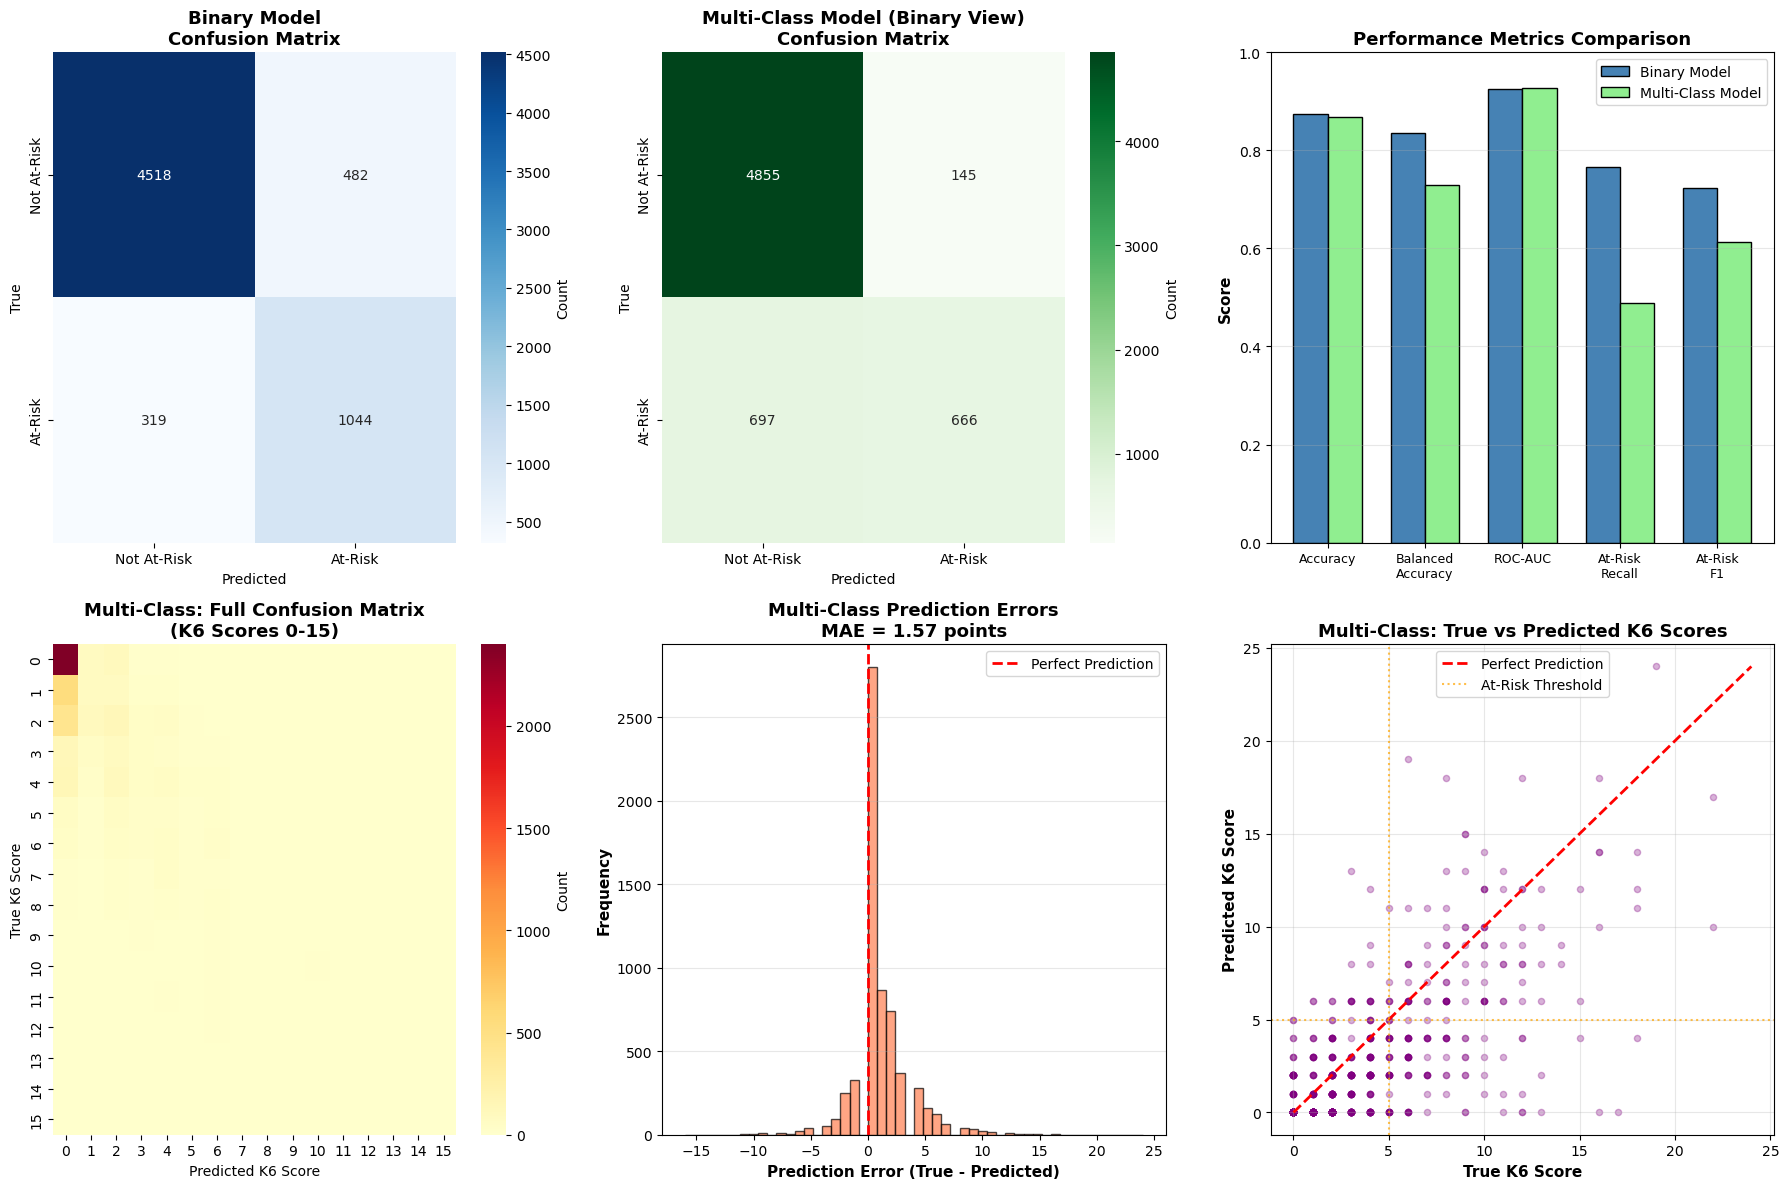

In [42]:
print("\n" + "="*80)
print("VISUALIZATION: Model Performance Comparison")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Confusion Matrix - Binary Model
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not At-Risk', 'At-Risk'],
            yticklabels=['Not At-Risk', 'At-Risk'],
            ax=axes[0, 0], cbar_kws={'label': 'Count'})
axes[0, 0].set_title('Binary Model\nConfusion Matrix', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('True')

# 2. Confusion Matrix - Multi-Class (as binary)
sns.heatmap(cm_multiclass, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not At-Risk', 'At-Risk'],
            yticklabels=['Not At-Risk', 'At-Risk'],
            ax=axes[0, 1], cbar_kws={'label': 'Count'})
axes[0, 1].set_title('Multi-Class Model (Binary View)\nConfusion Matrix', 
                     fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')

# 3. Metric Comparison Bar Chart
metrics_to_plot = ['accuracy', 'balanced_accuracy', 'roc_auc', 'at_risk_recall', 'at_risk_f1']
metric_labels = ['Accuracy', 'Balanced\nAccuracy', 'ROC-AUC', 'At-Risk\nRecall', 'At-Risk\nF1']

binary_vals = [binary_results[m] for m in metrics_to_plot]
multiclass_vals = [multiclass_results[m] if m in multiclass_results else multiclass_results.get('binary_'+m, 0) 
                   for m in metrics_to_plot]

x = np.arange(len(metric_labels))
width = 0.35

axes[0, 2].bar(x - width/2, binary_vals, width, label='Binary Model', 
              color='steelblue', edgecolor='black')
axes[0, 2].bar(x + width/2, multiclass_vals, width, label='Multi-Class Model',
              color='lightgreen', edgecolor='black')
axes[0, 2].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[0, 2].set_title('Performance Metrics Comparison', fontsize=13, fontweight='bold')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(metric_labels, fontsize=9)
axes[0, 2].legend(fontsize=10)
axes[0, 2].set_ylim([0, 1])
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Multi-class confusion matrix (full)
# Show only K6 scores 0-15 for readability
k6_scores_to_show = [i for i in range(16)]
cm_multiclass_full = confusion_matrix(y_test_multiclass, y_test_pred_multiclass)
cm_subset = cm_multiclass_full[:16, :16]

sns.heatmap(cm_subset, annot=False, cmap='YlOrRd', ax=axes[1, 0],
           cbar_kws={'label': 'Count'})
axes[1, 0].set_title('Multi-Class: Full Confusion Matrix\n(K6 Scores 0-15)',
                    fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Predicted K6 Score')
axes[1, 0].set_ylabel('True K6 Score')

# 5. Prediction Error Distribution (Multi-class)
prediction_errors = y_test_multiclass - y_test_pred_multiclass
axes[1, 1].hist(prediction_errors, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Prediction Error (True - Predicted)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title(f'Multi-Class Prediction Errors\nMAE = {mae:.2f} points',
                    fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Actual vs Predicted (Multi-class) - Scatter
sample_size = min(1000, len(y_test_multiclass))
sample_idx = np.random.choice(len(y_test_multiclass), sample_size, replace=False)

axes[1, 2].scatter(y_test_multiclass[sample_idx], y_test_pred_multiclass[sample_idx],
                  alpha=0.3, s=20, color='purple')
axes[1, 2].plot([0, 24], [0, 24], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 2].axhline(5, color='orange', linestyle=':', alpha=0.7, label='At-Risk Threshold')
axes[1, 2].axvline(5, color='orange', linestyle=':', alpha=0.7)
axes[1, 2].set_xlabel('True K6 Score', fontsize=11, fontweight='bold')
axes[1, 2].set_ylabel('Predicted K6 Score', fontsize=11, fontweight='bold')
axes[1, 2].set_title('Multi-Class: True vs Predicted K6 Scores',
                    fontsize=13, fontweight='bold')
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

EXPERIMENT: 3-CLASS CLASSIFICATION (Low / Moderate / Severe)

3-Class Distribution:

Training Set:
  Class 0 - Low (K6<5): 14,997 (78.6%)
  Class 1 - Moderate (5≤K6<13): 3,412 (17.9%)
  Class 2 - Severe (K6≥13): 678 (3.6%)

Validation Set:
  Class 0 - Low (K6<5): 4,999 (78.6%)
  Class 1 - Moderate (5≤K6<13): 1,121 (17.6%)
  Class 2 - Severe (K6≥13): 243 (3.8%)

Test Set:
  Class 0 - Low (K6<5): 5,000 (78.6%)
  Class 1 - Moderate (5≤K6<13): 1,146 (18.0%)
  Class 2 - Severe (K6≥13): 217 (3.4%)


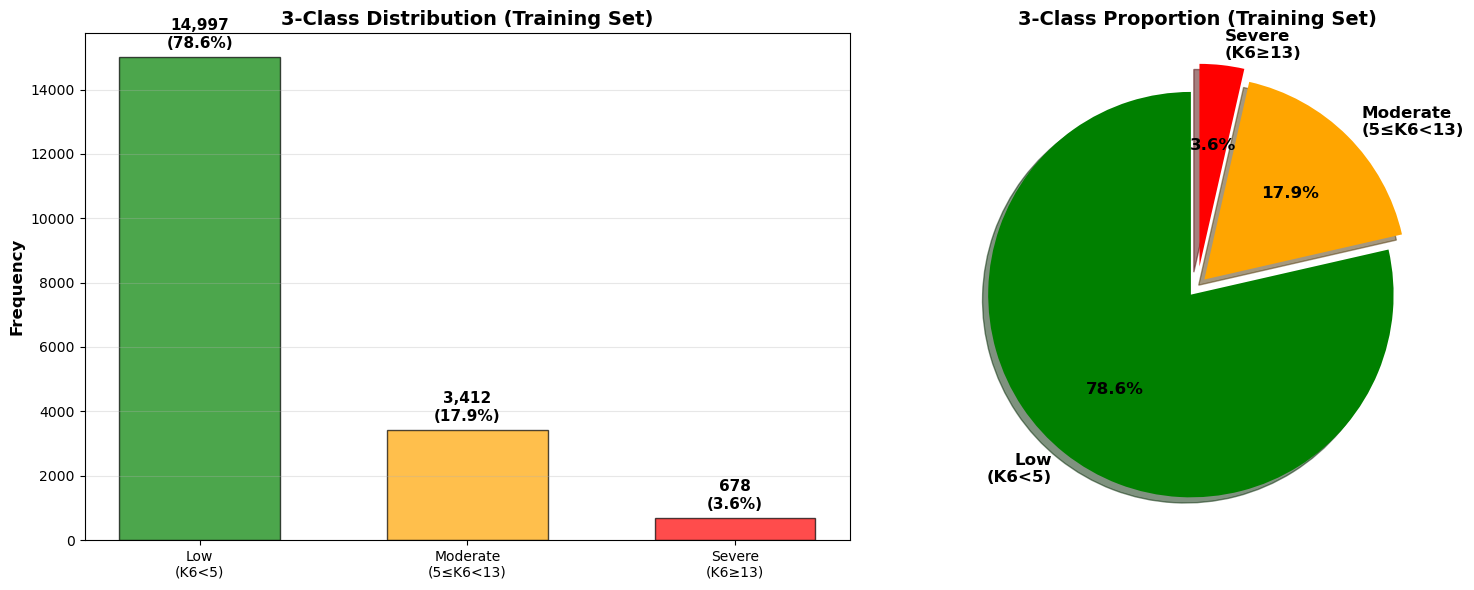


⚠️ Class Imbalance Note:
  • Low distress is majority class (78.6%)
  • Severe distress is rare (3.6%)
  • Imbalance ratio: 22.1:1 (Low:Severe)


In [43]:
print("="*80)
print("EXPERIMENT: 3-CLASS CLASSIFICATION (Low / Moderate / Severe)")
print("="*80)

import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, balanced_accuracy_score,
                             f1_score, cohen_kappa_score)
import matplotlib.pyplot as plt
import seaborn as sns

# Define 3-class labels based on clinical thresholds
def create_3class_labels(k6_scores):
    """
    Create 3-class labels:
    - Class 0: Low distress (K6 < 5)
    - Class 1: Moderate distress (5 ≤ K6 < 13)
    - Class 2: Severe distress (K6 ≥ 13)
    """
    labels = np.zeros(len(k6_scores), dtype=int)
    labels[(k6_scores >= 5) & (k6_scores < 13)] = 1
    labels[k6_scores >= 13] = 2
    return labels

# Get K6 scores
k6_train = df_clean.loc[X_train.index, 'K6_SCORE'].values
k6_val = df_clean.loc[X_val.index, 'K6_SCORE'].values
k6_test = df_clean.loc[X_test.index, 'K6_SCORE'].values

# Create 3-class targets
y_train_3class = create_3class_labels(k6_train)
y_val_3class = create_3class_labels(k6_val)
y_test_3class = create_3class_labels(k6_test)

print("\n3-Class Distribution:")
print("\nTraining Set:")
train_dist = pd.Series(y_train_3class).value_counts().sort_index()
for cls, count in train_dist.items():
    class_names = ['Low (K6<5)', 'Moderate (5≤K6<13)', 'Severe (K6≥13)']
    print(f"  Class {cls} - {class_names[cls]}: {count:,} ({count/len(y_train_3class)*100:.1f}%)")

print("\nValidation Set:")
val_dist = pd.Series(y_val_3class).value_counts().sort_index()
for cls, count in val_dist.items():
    class_names = ['Low (K6<5)', 'Moderate (5≤K6<13)', 'Severe (K6≥13)']
    print(f"  Class {cls} - {class_names[cls]}: {count:,} ({count/len(y_val_3class)*100:.1f}%)")

print("\nTest Set:")
test_dist = pd.Series(y_test_3class).value_counts().sort_index()
for cls, count in test_dist.items():
    class_names = ['Low (K6<5)', 'Moderate (5≤K6<13)', 'Severe (K6≥13)']
    print(f"  Class {cls} - {class_names[cls]}: {count:,} ({count/len(y_test_3class)*100:.1f}%)")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
class_labels = ['Low\n(K6<5)', 'Moderate\n(5≤K6<13)', 'Severe\n(K6≥13)']
train_counts = [train_dist.get(i, 0) for i in range(3)]
colors = ['green', 'orange', 'red']

axes[0].bar(class_labels, train_counts, color=colors, edgecolor='black', alpha=0.7, width=0.6)
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('3-Class Distribution (Training Set)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add percentages on bars
for i, (count, color) in enumerate(zip(train_counts, colors)):
    pct = count / sum(train_counts) * 100
    axes[0].text(i, count + max(train_counts)*0.02, f'{count:,}\n({pct:.1f}%)', 
                ha='center', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(train_counts, labels=class_labels, colors=colors, autopct='%1.1f%%',
           startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'},
           explode=(0.05, 0.05, 0.1), shadow=True)
axes[1].set_title('3-Class Proportion (Training Set)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ Class Imbalance Note:")
print(f"  • Low distress is majority class ({train_counts[0]/sum(train_counts)*100:.1f}%)")
print(f"  • Severe distress is rare ({train_counts[2]/sum(train_counts)*100:.1f}%)")
print(f"  • Imbalance ratio: {train_counts[0]/train_counts[2]:.1f}:1 (Low:Severe)")

In [44]:
print("\n" + "="*80)
print("TRAINING: 3-Class XGBoost Model")
print("="*80)

# 3-class XGBoost
model_3class = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='multi:softmax',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1
)

print("Training 3-class model...")
model_3class.fit(
    X_train_scaled, y_train_3class,
    eval_set=[(X_val_scaled, y_val_3class)],
    verbose=False
)

# Predictions
y_test_pred_3class = model_3class.predict(X_test_scaled)
y_test_proba_3class = model_3class.predict_proba(X_test_scaled)

print("✓ Model trained\n")

# Classification Report
print("="*80)
print("3-CLASS MODEL: Test Set Performance")
print("="*80)

class_names = ['Low (K6<5)', 'Moderate (5≤K6<13)', 'Severe (K6≥13)']
print("\nClassification Report:")
print(classification_report(y_test_3class, y_test_pred_3class, 
                          target_names=class_names, digits=4))

# Overall metrics
acc_3class = accuracy_score(y_test_3class, y_test_pred_3class)
balanced_acc_3class = balanced_accuracy_score(y_test_3class, y_test_pred_3class)
f1_macro_3class = f1_score(y_test_3class, y_test_pred_3class, average='macro')
f1_weighted_3class = f1_score(y_test_3class, y_test_pred_3class, average='weighted')
kappa_3class = cohen_kappa_score(y_test_3class, y_test_pred_3class)

print(f"\nOverall Metrics:")
print(f"  Accuracy: {acc_3class:.4f} ({acc_3class*100:.1f}%)")
print(f"  Balanced Accuracy: {balanced_acc_3class:.4f} ({balanced_acc_3class*100:.1f}%)")
print(f"  Macro F1: {f1_macro_3class:.4f}")
print(f"  Weighted F1: {f1_weighted_3class:.4f}")
print(f"  Cohen's Kappa: {kappa_3class:.4f}")

# Confusion Matrix
cm_3class = confusion_matrix(y_test_3class, y_test_pred_3class)

print("\n" + "-"*80)
print("Confusion Matrix:")
print("-"*80)
print("\n                 Predicted")
print("               Low    Moderate  Severe")
print(f"Actual Low     {cm_3class[0,0]:5d}   {cm_3class[0,1]:5d}     {cm_3class[0,2]:5d}")
print(f"Actual Mod     {cm_3class[1,0]:5d}   {cm_3class[1,1]:5d}     {cm_3class[1,2]:5d}")
print(f"Actual Severe  {cm_3class[2,0]:5d}   {cm_3class[2,1]:5d}     {cm_3class[2,2]:5d}")

# Per-class metrics
for i, class_name in enumerate(class_names):
    tp = cm_3class[i, i]
    total = cm_3class[i, :].sum()
    recall = tp / total if total > 0 else 0
    
    total_pred = cm_3class[:, i].sum()
    precision = tp / total_pred if total_pred > 0 else 0
    
    print(f"\n{class_name}:")
    print(f"  Recall: {recall:.4f} ({recall*100:.1f}%) - Identifies {tp}/{total} correctly")
    print(f"  Precision: {precision:.4f} ({precision*100:.1f}%) - {tp}/{total_pred} predicted are correct")


TRAINING: 3-Class XGBoost Model
Training 3-class model...
✓ Model trained

3-CLASS MODEL: Test Set Performance

Classification Report:
                    precision    recall  f1-score   support

        Low (K6<5)     0.9059    0.9532    0.9290      5000
Moderate (5≤K6<13)     0.6406    0.5428    0.5876      1146
    Severe (K6≥13)     0.6718    0.4055    0.5057       217

          accuracy                         0.8606      6363
         macro avg     0.7394    0.6338    0.6741      6363
      weighted avg     0.8501    0.8606    0.8530      6363


Overall Metrics:
  Accuracy: 0.8606 (86.1%)
  Balanced Accuracy: 0.6338 (63.4%)
  Macro F1: 0.6741
  Weighted F1: 0.8530
  Cohen's Kappa: 0.5672

--------------------------------------------------------------------------------
Confusion Matrix:
--------------------------------------------------------------------------------

                 Predicted
               Low    Moderate  Severe
Actual Low      4766     234         0
Actual M

In [45]:
print("\n" + "="*80)
print("3-CLASS MODEL: Binary Classification View (Low vs At-Risk)")
print("="*80)

# Convert 3-class predictions to binary
# Low (0) = Not at-risk, Moderate/Severe (1,2) = At-risk
y_test_3class_binary = (y_test_3class > 0).astype(int)
y_pred_3class_binary = (y_test_pred_3class > 0).astype(int)

# Probability of being at-risk (Moderate OR Severe)
y_proba_3class_at_risk = y_test_proba_3class[:, 1] + y_test_proba_3class[:, 2]

print("\nBinary Classification Report (Low vs At-Risk):")
print(classification_report(y_test_3class_binary, y_pred_3class_binary,
                          target_names=['Not At-Risk', 'At-Risk'], digits=4))

# Binary metrics
acc_3class_binary = accuracy_score(y_test_3class_binary, y_pred_3class_binary)
balanced_acc_3class_binary = balanced_accuracy_score(y_test_3class_binary, y_pred_3class_binary)
roc_auc_3class = roc_auc_score(y_test_3class_binary, y_proba_3class_at_risk)
f1_macro_3class_binary = f1_score(y_test_3class_binary, y_pred_3class_binary, average='macro')
f1_at_risk_3class = f1_score(y_test_3class_binary, y_pred_3class_binary, pos_label=1)

cm_3class_binary = confusion_matrix(y_test_3class_binary, y_pred_3class_binary)
sensitivity_3class = cm_3class_binary[1,1] / (cm_3class_binary[1,1] + cm_3class_binary[1,0])
specificity_3class = cm_3class_binary[0,0] / (cm_3class_binary[0,0] + cm_3class_binary[0,1])
ppv_3class = cm_3class_binary[1,1] / (cm_3class_binary[1,1] + cm_3class_binary[0,1])

print(f"\nBinary Metrics:")
print(f"  Accuracy: {acc_3class_binary:.4f}")
print(f"  Balanced Accuracy: {balanced_acc_3class_binary:.4f}")
print(f"  ROC-AUC: {roc_auc_3class:.4f}")
print(f"  At-Risk Recall: {sensitivity_3class:.4f} ({sensitivity_3class*100:.1f}%)")
print(f"  At-Risk Precision: {ppv_3class:.4f} ({ppv_3class*100:.1f}%)")
print(f"  At-Risk F1: {f1_at_risk_3class:.4f}")

# Store results
results_3class = {
    'accuracy_3class': acc_3class,
    'balanced_accuracy_3class': balanced_acc_3class,
    'f1_macro_3class': f1_macro_3class,
    'kappa': kappa_3class,
    'binary_accuracy': acc_3class_binary,
    'balanced_accuracy_binary': balanced_acc_3class_binary,
    'roc_auc': roc_auc_3class,
    'at_risk_recall': sensitivity_3class,
    'at_risk_precision': ppv_3class,
    'at_risk_f1': f1_at_risk_3class
}


3-CLASS MODEL: Binary Classification View (Low vs At-Risk)

Binary Classification Report (Low vs At-Risk):
              precision    recall  f1-score   support

 Not At-Risk     0.9059    0.9532    0.9290      5000
     At-Risk     0.7877    0.6368    0.7043      1363

    accuracy                         0.8854      6363
   macro avg     0.8468    0.7950    0.8166      6363
weighted avg     0.8806    0.8854    0.8808      6363


Binary Metrics:
  Accuracy: 0.8854
  Balanced Accuracy: 0.7950
  ROC-AUC: 0.9246
  At-Risk Recall: 0.6368 (63.7%)
  At-Risk Precision: 0.7877 (78.8%)
  At-Risk F1: 0.7043


In [46]:
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON: Binary vs 3-Class vs 25-Class")
print("="*80)

comparison_3way = pd.DataFrame({
    'Metric': [
        'Overall Accuracy',
        'Balanced Accuracy',
        'ROC-AUC (Binary View)',
        'Macro F1',
        'At-Risk Recall',
        'At-Risk Precision',
        'At-Risk F1',
        '---',
        'Classes',
        'Interpretability',
        'Clinical Utility'
    ],
    'Binary Model': [
        f"{binary_results['accuracy']:.4f}",
        f"{binary_results['balanced_accuracy']:.4f}",
        f"{binary_results['roc_auc']:.4f}",
        f"{binary_results['f1_macro']:.4f}",
        f"{binary_results['at_risk_recall']:.4f}",
        f"{cm_binary[1,1]/(cm_binary[1,1]+cm_binary[0,1]):.4f}",
        f"{binary_results['at_risk_f1']:.4f}",
        '---',
        '2',
        'High',
        'Screening (Yes/No)'
    ],
    '3-Class Model': [
        f"{results_3class['binary_accuracy']:.4f}",
        f"{results_3class['balanced_accuracy_binary']:.4f}",
        f"{results_3class['roc_auc']:.4f}",
        f"{results_3class['f1_macro_3class']:.4f}",
        f"{results_3class['at_risk_recall']:.4f}",
        f"{results_3class['at_risk_precision']:.4f}",
        f"{results_3class['at_risk_f1']:.4f}",
        '---',
        '3',
        'Medium',
        'Stratified Intervention'
    ],
    '25-Class Model': [
        f"{multiclass_results['binary_accuracy']:.4f}",
        f"{multiclass_results['balanced_accuracy']:.4f}",
        f"{multiclass_results['roc_auc']:.4f}",
        f"{multiclass_results['f1_macro']:.4f}",
        f"{multiclass_results['at_risk_recall']:.4f}",
        f"{cm_multiclass[1,1]/(cm_multiclass[1,1]+cm_multiclass[0,1]):.4f}",
        f"{multiclass_results['at_risk_f1']:.4f}",
        '---',
        '25',
        'Low',
        'Precise Severity'
    ]
})

display(comparison_3way)

# Determine best for at-risk identification
recalls = {
    'Binary': binary_results['at_risk_recall'],
    '3-Class': results_3class['at_risk_recall'],
    '25-Class': multiclass_results['at_risk_recall']
}

best_model = max(recalls, key=recalls.get)
print(f"\n🏆 BEST AT-RISK RECALL: {best_model} ({recalls[best_model]*100:.1f}%)")


COMPREHENSIVE COMPARISON: Binary vs 3-Class vs 25-Class


,Metric,Binary Model,3-Class Model,25-Class Model
0,Overall Accuracy,0.8741,0.8854,0.8677
1,Balanced Accuracy,0.8348,0.7950,0.7298
2,ROC-AUC (Binary View),0.9240,0.9246,0.9263
3,Macro F1,0.8207,0.6741,0.7665
4,At-Risk Recall,0.7660,0.6368,0.4886
5,At-Risk Precision,0.6841,0.7877,0.8212
6,At-Risk F1,0.7227,0.7043,0.6127
7,---,---,---,---
8,Classes,2,3,25
9,Interpretability,High,Medium,Low



🏆 BEST AT-RISK RECALL: Binary (76.6%)
